In [236]:
%matplotlib inline

from pathlib import Path
import time
import traceback
from importlib import reload

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='muted')
from matplotlib_venn import venn2, venn3

from TreeMazeAnalyses2.Analyses import subject_info as si

from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
%%time
si = reload(si)
subjects = ['Cl']
overwrite = False
for subject in subjects:
    subject_info = si.SubjectInfo(subject, overwrite=overwrite)

CPU times: user 78.8 ms, sys: 3.87 ms, total: 82.7 ms
Wall time: 80.9 ms


In [ ]:
%%time
#subject_info.update_clusters()

### show #s of curated cell/mua on each tt per session

In [14]:
subject_info.sort_tables['curated']

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Cl_T3g_010218,1,2,1,10,0,0,0,1,0,6,0,0,0,0,1,0
Cl_OF_010218,0,4,1,7,0,0,0,0,0,9,0,1,3,0,1,0
Cl_T3g_010318,0,2,2,2,0,0,0,0,0,4,0,0,0,0,1,0
Cl_OF_010318,0,2,6,3,0,0,0,1,0,8,1,2,0,0,0,1
Cl_OF_010418,0,0,9,8,0,0,0,0,0,6,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cl_T3i_021419,0,6,0,14,0,0,0,0,0,2,0,1,0,0,0,0
Cl_T3g_021519,0,3,0,7,0,0,0,0,0,2,0,0,0,0,0,0
Cl_OF_021519,0,5,0,8,0,0,0,0,0,0,0,0,0,0,0,0
Cl_T3i_021519,0,4,0,7,0,0,0,0,0,0,0,0,0,0,0,0


### see sessions that are matched for depth for a given tetrode

In [193]:
tt = 4
depth = 14.25
subject_info.tt_depth_match[tt][depth]

['Cl_T3g_010218',
 'Cl_OF_010218',
 'Cl_T3g_010318',
 'Cl_OF_010318',
 'Cl_OF_010418',
 'Cl_T3g_010418',
 'Cl_T3g_123118',
 'Cl_OF_123118',
 'Cl_T3g_010619',
 'Cl_OF_010619',
 'Cl_T3g_010719',
 'Cl_OF_010719']

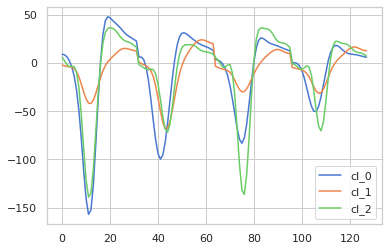

In [194]:
tt=4
session = 'Cl_T3g_010218'
cluster_ids = subject_info.session_clusters[session]['cell_IDs'][tt]
a=subject_info.get_session_tt_wf(session,4, cluster_ids=cluster_ids)
_=plt.plot(a.mean(axis=1).T)
plt.legend(['cl_'+str(ii) for ii in range(3)])


### select cluster match analyses based on isolated cells

In [6]:
%%time
analyses = []
for tt in np.arange(1,17):
    tt_depths = list(subject_info.tt_depth_match[tt].keys())
    for tt_d in tt_depths:
        tt_d_sessions = subject_info.tt_depth_match[tt][tt_d]
        # check if there are more 2 or more sessions with units
        n_cells_session = np.zeros(len(tt_d_sessions),dtype=int)
        for ii, session in enumerate(tt_d_sessions):
            session_cell_IDs = subject_info.session_clusters[session]['cell_IDs']
            if tt in session_cell_IDs.keys():
                n_cells_session[ii] = len(session_cell_IDs[tt])
        sessions_with_cells = np.where(n_cells_session>0)[0]
        if len(sessions_with_cells)>=2:
            analyses.append( (tt, 
                              tt_d, 
                              np.array(tt_d_sessions)[sessions_with_cells].tolist(), 
                              n_cells_session[sessions_with_cells].tolist())
                           )


CPU times: user 7.07 ms, sys: 0 ns, total: 7.07 ms
Wall time: 6.91 ms


In [18]:
analyses[2]

(2, 12.0, ['Cl_T3g_112118_0001', 'Cl_OF_112118'], [3, 4])

In [199]:
n_wf = 1000
n_samps = 32*4
analyses_id = 15
tt, d, sessions, n_session_units = analyses[analyses_id]

X = np.empty((0,n_wf,n_samps),dtype=np.float16)
for session in sessions:
    cluster_ids = subject_info.session_clusters[session]['cell_IDs'][tt]
    session_cell_wf = subject_info.get_session_tt_wf(session, tt, cluster_ids=cluster_ids, n_wf=n_wf)
    X = np.concatenate((X,session_cell_wf),axis=0)

n_clusters = np.array(n_session_units).sum()
cluster_labels = np.arange(n_clusters).repeat(n_wf)
for session_idx, n_session_clusters in enumerate(n_session_units):
    if session_idx==0:
        session_labels = np.zeros(n_session_clusters*n_wf, dtype=int)
    else:
        session_labels = np.concatenate( (session_labels, session_idx*np.ones(n_session_clusters*n_wf )) ).astype(int)
X = X.reshape(-1, X.shape[-1])


In [200]:
print(f' n sessions {len(sessions)} \n n clusters {n_clusters} \n Data Shape {X.shape} \n Clusters Shape {cluster_labels.shape} \n Session Shape {session_labels.shape}') 

 n sessions 10 
 n clusters 37 
 Data Shape (37000, 128) 
 Clusters Shape (37000,) 
 Session Shape (37000,)


In [201]:
n_session_units
session_clusters_id = [[ii]*session_units for ii,session_units in enumerate(n_session_units)]
session_clusters_id = [item for sublist in session_clusters_id for item in sublist]
session_clusters_id

[0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 8,
 8,
 9,
 9,
 9,
 9]

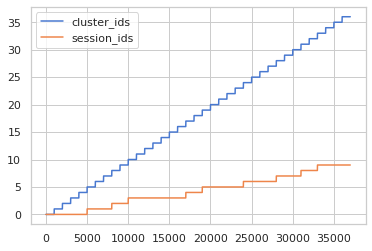

In [202]:
plt.plot(cluster_labels, label = 'cluster_ids')
plt.plot(session_labels, label = 'session_ids')
plt.legend()

## Apply tsne to the waveforms

In [203]:
%%time
tsne = TSNE(n_jobs=-1, perplexity=30)
X_tsne=tsne.fit_transform(X)
print(f' TSNE Data Shape {X_tsne.shape}')

 TSNE Data Shape (37000, 2)
CPU times: user 44min 42s, sys: 24.3 s, total: 45min 7s
Wall time: 2min 26s


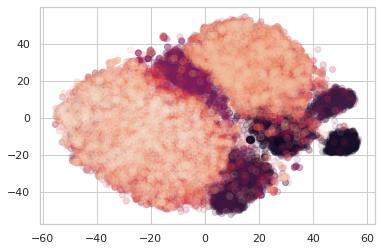

In [204]:
plt.scatter(X_tsne[:,0], X_tsne[:,1],c=cluster_labels, alpha=0.1)

In [205]:
%%time
X_pca = PCA(n_components=2).fit_transform(X)

CPU times: user 991 ms, sys: 43.9 ms, total: 1.03 s
Wall time: 132 ms


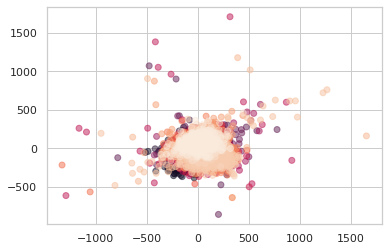

In [206]:
plt.scatter(X_pca[:,0], X_pca[:,1],c=cluster_labels, alpha=0.5)

## create confidence ellipsoids around tsne clusters

In [171]:
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    ax.add_patch(ellipse)
    return ax, ellipse

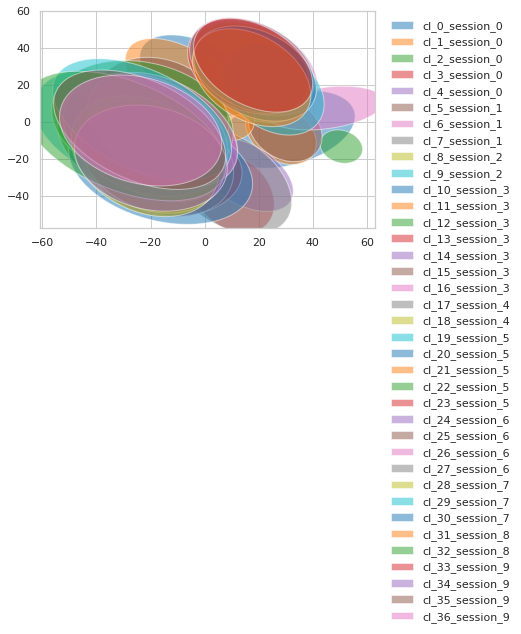

In [207]:
f,ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
polys = []
for cluster in range(n_clusters):
    x = X_tsne[cluster_labels==cluster,0]
    y = X_tsne[cluster_labels==cluster,1]

    label_str = f'cl_{cluster}_session_{session_clusters_id[cluster]}'
    #ax.scatter(x,y, color=colors[cluster], alpha=0.1)
    ax, ellipse = confidence_ellipse(x, y, ax=ax, facecolor=colors[np.mod(cluster,10)], alpha=0.5, n_std=2, label=label_str)
    polys.append(Polygon(ellipse.properties()['verts']))
ax.set_xlim(np.array([X_tsne[:,0].min(),X_tsne[:,0].max()])*1.1 )
ax.set_ylim(np.array([X_tsne[:,1].min(),X_tsne[:,1].max()])*1.1 )
ax.legend(bbox_to_anchor=(1.02, 1), frameon=False)

In [235]:
ellipse.set_transform(transf)

In [230]:
ax.transData

## asymetrical overlap between ellipsoids

In [209]:
pct_overlap = np.zeros((n_clusters,n_clusters))

for cluster1 in range(n_clusters):
    poly1 = polys[cluster1]
    area_cl1 = poly1.area
    for cluster2 in range(n_clusters):
        pct_overlap[cluster1,cluster2] = poly1.intersection(polys[cluster2]).area/area_cl1
        

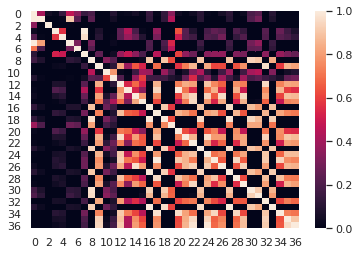

In [210]:
sns.heatmap(pct_overlap)

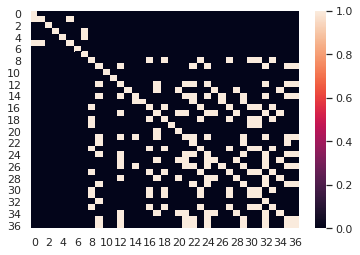

In [211]:
sns.heatmap(pct_overlap>0.8)

## symetrical overlap

In [212]:
pct_overlap2 = np.zeros((n_clusters,n_clusters))

for cluster1 in range(n_clusters):
    poly1 = polys[cluster1]
    area_cl1 = poly1.area
    for cluster2 in range(n_clusters):
        poly2 = polys[cluster2]
        area_cl2 = poly2.area
        pct_overlap[cluster1,cluster2] = 2*poly1.intersection(poly2).area/(area_cl1+area_cl2)

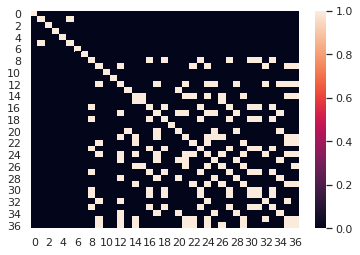

In [213]:
sns.heatmap(pct_overlap>0.8)

10

In [178]:
mwf = X.reshape(n_units,1000,128).mean(axis=1)

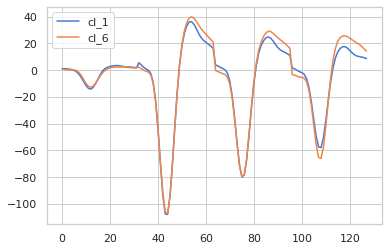

In [195]:
selected_cl = [1,6] 
plt.plot(mwf[selected_cl,:].T)
plt.legend(['cl_'+str(ii) for ii in selected_cl])

In [63]:
n_x_bins = 100
n_y_bins = 100
x_min, x_max = X_tsne[:,0].min(), X_tsne[:,0].max()
y_min, y_max = X_tsne[:,1].min(), X_tsne[:,1].max()
x_bin_edges = np.linspace(x_min*1.01,x_max*1.01, n_x_bins+1)
y_bin_edges = np.linspace(y_min*1.01,y_max*1.01, n_y_bins+1)

X_cluster_images = np.zeros((n_clusters, n_y_bins, n_x_bins))
for cluster in range(n_clusters):
    x = X_tsne[cluster_labels==cluster,0]
    y = X_tsne[cluster_labels==cluster,1]
    X_cluster_images[cluster], _, _ = np.histogram2d(y,x, bins=np.array( (y_bin_edges,x_bin_edges )))

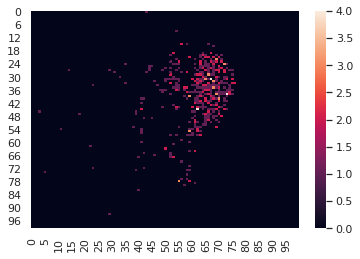

In [72]:
sns.heatmap(X_cluster_images[4])

In [53]:
x=np.arange(100).reshape(4,-1)
spk_times = np.arange(6,25,5)
wf_samps = np.arange(-2,2)
print(x)
print(spk_times)
#print(x[:,])

[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24]
 [25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
  49]
 [50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
  74]
 [75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98
  99]]
[ 6 11 16 21]


Init signature: zip(self, /, *args, **kwargs)
Docstring:     
zip(iter1 [,iter2 [...]]) --> zip object

Return a zip object whose .__next__() method returns a tuple where
the i-th element comes from the i-th iterable argument.  The .__next__()
method continues until the shortest iterable in the argument sequence
is exhausted and then it raises StopIteration.
Type:           type
Subclasses:     


/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


95

In [16]:
#np.array(list(subject_info.session_clusters[session]['cell_IDs'].keys()))-1
subject_info.session_clusters[session]['cell_IDs'].values()

dict_values([[], [1, 15], [4, 9, 18], [], [], [], [], [], [], [], [], [], [], []])

In [16]:
a=subject_info._sort_tables()

ValueError: shape mismatch: value array of shape (15,) could not be broadcast to indexing result of shape (13,)

In [ ]:
subject_info._get_clusters(True)
subject_info._get_sort_tables()

In [18]:
subject_info.session_clusters['Cl_OF_010218']['mua_IDs']

{'1': [],
 '2': [0, 3, 4, 14],
 '3': [],
 '4': [1, 9, 12],
 '5': [],
 '6': [],
 '7': [],
 '8': [],
 '9': [],
 '10': [5, 7, 9, 12, 15, 16],
 '11': [],
 '12': [8],
 '13': [2, 6, 15],
 '14': [],
 '15': [4]}

In [12]:
subject_info.tetrodes

/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [42]:
x=np.fromfile(subject_info.session_paths['Cl_T3g_010218']['Sorted']/'tt_4/KS2/recording.dat', dtype=np.float16)

In [36]:
o=np.load(subject_info.session_paths['Cl_T3g_010218']['PreProcessed']/'tt_4.npy')

In [54]:
xx=x.reshape(-1,4)

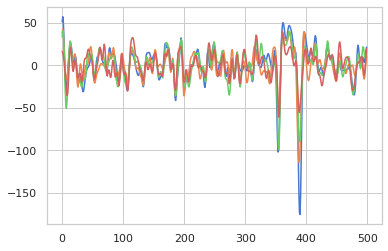

In [57]:
i=100
wl = 500
w = np.arange(wl)+ i*wl
plt.plot(xx[w,:])

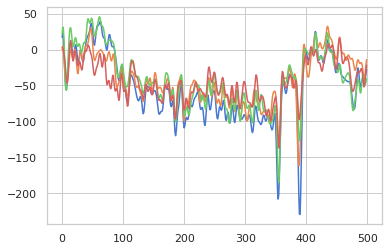

In [58]:
plt.plot(o[:,w].T)

In [8]:
spike_times=np.load(subject_info.session_paths['Cl_T3g_010218']['Sorted']/'tt_4/KS2/spike_times.npy')
spike_clusters=np.load(subject_info.session_paths['Cl_T3g_010218']['Sorted']/'tt_4/KS2/spike_clusters.npy')


In [15]:
spike_times[spike_clusters==1].flatten()

array([    13868,     21868,     30522, ..., 129957736, 129963708,
       129975802], dtype=uint32)

In [72]:
isinstance(spike_times, np.narray)

True

In [200]:
cluster_groups = pd.read_csv(subject_info.session_paths['Cl_T3g_010218']['Sorted']/'tt_4/KS2/cluster_group.tsv', sep='\t')

In [207]:
valid_units = cluster_groups.group.isin(['good','mua'])
cluster_groups.cluster_id[valid_units].values

array([ 0,  2,  3,  4,  8, 11, 14, 16, 17, 18])

In [205]:
cluster_groups

,cluster_id,group
0,0,good
1,1,noise
2,2,mua
3,3,good
4,4,mua
5,5,noise
6,8,mua
7,11,mua
8,12,noise
9,14,mua


In [154]:
# p = Path('/home/alexgonzalez/Documents/data/ag_rat_metadata/Tetrodes.xlsx')
# tt_pos = pd.read_excel(p.open(mode='rb'), sheet_name=subject, engine='openpyxl')
# tt_pos['Date'] = [date.strftime('%m%d%y') if not pd.isnull(date) else '' for date in tt_pos['Date']]
# tt_pos = tt_pos[tt_pos['Date']!='']
# tt_pos = tt_pos.set_index('Date')

p = Path(subject_info.results_path.parent / 'Cl_tetrodes.csv')
tt_pos = pd.read_csv(p)

tt_pos['Date'] = pd.to_datetime(tt_pos['Date']).dt.strftime('%m%d%y')
tt_pos = tt_pos.set_index('Date')

tt_pos=tt_pos[ ['TT'+str(tt)+'_overall' for tt in range(1,17)]] 

In [155]:
tt_pos

,TT1_overall,TT2_overall,TT3_overall,TT4_overall,TT5_overall,TT6_overall,TT7_overall,TT8_overall,TT9_overall,TT10_overall,TT11_overall,TT12_overall,TT13_overall,TT14_overall,TT15_overall,TT16_overall
Date,,,,,,,,,,,,,,,,
112118,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00
112218,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00
112318,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25
112418,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25
112518,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
021319,17.50,17.00,17.25,16.50,17.50,17.00,17.50,17.00,17.25,16.25,17.25,17.00,17.50,17.50,17.00,17.25
021419,17.75,17.25,17.50,16.75,17.75,17.25,17.75,17.25,17.50,16.50,17.50,17.25,17.75,17.75,17.25,17.50
021519,17.75,17.25,17.50,16.75,17.75,17.25,17.75,17.25,17.50,16.50,17.50,17.25,17.75,17.75,17.25,17.50


In [83]:
session_dates

{'Cl_T3g_010218': '010218',
 'Cl_OF_010218': '010218',
 'Cl_T3g_010318': '010318',
 'Cl_OF_010318': '010318',
 'Cl_OF_010418': '010418',
 'Cl_T3g_010418': '010418',
 'Cl_T3g_112118': '112118',
 'Cl_T3g_112118_0001': '112118',
 'Cl_OF_112118': '112118',
 'Cl_T3g_112318': '112318',
 'Cl_OF_112318': '112318',
 'Cl_T3g_112818': '112818',
 'Cl_OF_112818': '112818',
 'Cl_OF_112918': '112918',
 'Cl_T3g_112918': '112918',
 'Cl_T3g_113018': '113018',
 'Cl_OF_113018': '113018',
 'Cl_T3g_120118': '120118',
 'Cl_T3g_120118_0001': '120118',
 'Cl_T3g_120118_0': '120118',
 'Cl_OF_120118': '120118',
 'Cl_T3g_120318': '120318',
 'Cl_OF_120318': '120318',
 'Cl_OF_120418': '120418',
 'Cl_T3g_120418': '120418',
 'Cl_OF_120518': '120518',
 'Cl_T3g_120518': '120518',
 'Cl_OF_120618': '120618',
 'Cl_T3g_120618': '120618',
 'Cl_T3g_120718': '120718',
 'Cl_OF_120718': '120718',
 'Cl_OF_120918': '120918',
 'Cl_T3g_120918': '120918',
 'Cl_OF_121018': '121018',
 'Cl_T3g_121018': '121018',
 'Cl_T3g_121118': '12111

In [156]:
session_dates = {session:session.split('_')[2] for session in subject_info.sessions}
session_tt = pd.DataFrame(index = subject_info.sessions, columns = ['tt_' + str(tt) for tt in range(1,17)])

for session in subject_info.sessions:
    date = session_dates[session]
    if date in ['010218','010318','010418']:
        date = date[:5] + '9'
    session_tt.loc[session] = tt_pos.loc[date].values
    

/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [161]:
session_tt.iloc[:10]

,tt_1,tt_2,tt_3,tt_4,tt_5,tt_6,tt_7,tt_8,tt_9,tt_10,tt_11,tt_12,tt_13,tt_14,tt_15,tt_16
Cl_T3g_010218,14.75,14.25,14.5,14.25,14.75,14.5,14.75,14.5,14.75,13.75,14.5,14.25,14.75,14.75,14.5,14.5
Cl_OF_010218,14.75,14.25,14.5,14.25,14.75,14.5,14.75,14.5,14.75,13.75,14.5,14.25,14.75,14.75,14.5,14.5
Cl_T3g_010318,14.75,14.25,14.5,14.25,14.75,14.5,14.75,14.5,14.75,13.75,14.5,14.25,14.75,14.75,14.5,14.5
Cl_OF_010318,14.75,14.25,14.5,14.25,14.75,14.5,14.75,14.5,14.75,13.75,14.5,14.25,14.75,14.75,14.5,14.5
Cl_OF_010418,15,14.5,14.75,14.25,15,14.75,15,14.75,15,13.75,14.75,14.5,15,15,14.75,14.75
Cl_T3g_010418,15,14.5,14.75,14.25,15,14.75,15,14.75,15,13.75,14.75,14.5,15,15,14.75,14.75
Cl_T3g_112118,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12
Cl_T3g_112118_0001,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12
Cl_OF_112118,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12
Cl_T3g_112318,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25,12.25


In [173]:
n_tt = 16
tetrodes = range(1,n_tt+1)
tt_depth_matchs = {tt:{} for tt in tetrodes}

for tt in tetrodes:
    tt_str = 'tt_'+str(tt)
    tt_depths = session_tt[tt_str].unique()
    for depth in tt_depths:
        tt_depth_matchs[tt][depth] = list(session_tt[session_tt[tt_str]==depth].index)
        

In [11]:

np.sum([len(v) for k,v in subject_info.session_clusters['Cl_T3g_010218']['cell_IDs'].items()])
np.sum([len(v) for k,v in subject_info.session_clusters['Cl_T3g_010218']['mua_IDs'].items()])


15

In [16]:
a=np.array([len(v) for k,v in subject_info.session_clusters['Cl_T3g_010218']['cell_IDs'].items()])

b=np.array([len(v) for k,v in subject_info.session_clusters['Cl_T3g_010218']['mua_IDs'].items()])


In [19]:
subject_info.session_clusters['Cl_T3g_010218']['curated_TTs']

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 15]